In [1]:
!pip install prophet statsmodels tensorflow


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [7]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
)
df.columns = ["date", "temp"]
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

train = df.iloc[:-365]
test = df.iloc[-365:]


In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

arima = ARIMA(train, order=(5,1,0))
arima_fit = arima.fit()

arima_pred = arima_fit.forecast(len(test))
mae_arima = mean_absolute_error(test, arima_pred)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [9]:
from prophet import Prophet

prophet_df = train.reset_index()
prophet_df.columns = ["ds", "y"]

model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(prophet_df)

future = model_prophet.make_future_dataframe(periods=365)
forecast = model_prophet.predict(future)

prophet_pred = forecast["yhat"].iloc[-365:].values
mae_prophet = mean_absolute_error(test, prophet_pred)


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test = X[:-365], X[-365:]
y_train, y_test = y[:-365], y[-365:]


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm = Sequential([
    LSTM(50, input_shape=(30,1)),
    Dense(1)
])

lstm.compile(optimizer="adam", loss="mse")
lstm.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

lstm_pred = lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(
    np.concatenate([lstm_pred, np.zeros((365,1))], axis=1)
)[:,0]

mae_lstm = mean_absolute_error(test, lstm_pred)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [12]:
from tensorflow.keras.layers import GRU

gru = Sequential([
    GRU(50, input_shape=(30,1)),
    Dense(1)
])

gru.compile(optimizer="adam", loss="mse")
gru.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

gru_pred = gru.predict(X_test)
gru_pred = scaler.inverse_transform(
    np.concatenate([gru_pred, np.zeros((365,1))], axis=1)
)[:,0]

mae_gru = mean_absolute_error(test, gru_pred)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [13]:
results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "LSTM", "GRU"],
    "MAE": [mae_arima, mae_prophet, mae_lstm, mae_gru]
})

results


,Model,MAE
0,ARIMA,3.321689
1,Prophet,1.939139
2,LSTM,1.919198
3,GRU,1.811253


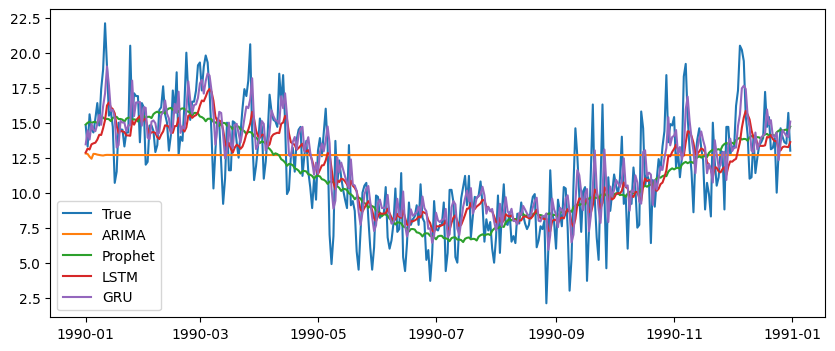

In [14]:
plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label="True")
plt.plot(test.index, arima_pred, label="ARIMA")
plt.plot(test.index, prophet_pred, label="Prophet")
plt.plot(test.index, lstm_pred, label="LSTM")
plt.plot(test.index, gru_pred, label="GRU")
plt.legend()
plt.show()
